# Предсказание аварий: описание проекта

**Цель проекта** - создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Предложение решения задачи от заказчика

* Создать модель предсказания ДТП (целеввое значение - `at_fault` в таблице `parties`)
* * Для модели выбрать тип виновника - только машина (**car**)
* * Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа **scratch**
* * Для моделирования ограничиться данными за 2012 год - они самые свежие
* * Обязательное условие - учесть фактор возраста автомобиля
* На основе модели исследовать основные факторы ДТП.
* Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
* * Возможно ли создать адекватную систему оценки водительского риска при выдаче авто?
* * Какие ещё факторы нужно учесть?
* * Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Общий план проекта

ТБД

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine, inspect
from ydata_profiling import ProfileReport

In [2]:
import yaml
from os import path, makedirs

In [37]:
pd.set_option('display.max_columns', None)

# Подключение к базе данных

In [3]:
# чтобы выложить проект на гитхабе и не палить параметры подключения,
# загрузим их из yml файла (файл добавлен в .gitignore)
with open('db_config.yml', 'r') as file:
    db_config = yaml.safe_load(file)

# строка для подключения к базе
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [29]:
# осмотр таблиц и клонок
inspector = inspect(engine)
table_names = inspector.get_table_names()

for table_name in table_names:
    columns = inspector.get_columns(table_name)
    print(f"Table: {table_name}")
    display(pd.DataFrame(columns))

Table: collisions


,name,type,nullable,default,autoincrement,comment
0,case_id,TEXT,True,None,False,None
1,county_city_location,TEXT,True,None,False,None
2,county_location,TEXT,True,None,False,None
3,distance,REAL,True,None,False,None
4,direction,TEXT,True,None,False,None
5,intersection,INTEGER,True,None,False,None
6,weather_1,TEXT,True,None,False,None
7,location_type,TEXT,True,None,False,None
8,collision_damage,TEXT,True,None,False,None
9,party_count,INTEGER,True,None,False,None


Table: case_ids


,name,type,nullable,default,autoincrement,comment
0,case_id,TEXT,True,None,False,None
1,db_year,TEXT,True,None,False,None


Table: parties


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,True,None,False,None
1,case_id,TEXT,True,None,False,None
2,party_number,INTEGER,True,None,False,None
3,party_type,TEXT,True,None,False,None
4,at_fault,INTEGER,True,None,False,None
5,insurance_premium,INTEGER,True,None,False,None
6,party_sobriety,TEXT,True,None,False,None
7,party_drug_physical,TEXT,True,None,False,None
8,cellphone_in_use,INTEGER,True,None,False,None


Table: vehicles


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,True,None,False,None
1,case_id,TEXT,True,None,False,None
2,party_number,INTEGER,True,None,False,None
3,vehicle_type,TEXT,True,None,False,None
4,vehicle_transmission,TEXT,True,None,False,None
5,vehicle_age,INTEGER,True,None,False,None


## Загрузка датасетов и отчётов

In [6]:
# процедура для загрузки датасетов
def download_tables(engine, table_names, datasets_folder='./datasets'):
    print("Start downloading tables:", table_names)
    if not path.exists(datasets_folder):
                makedirs(datasets_folder)

    for table_name in table_names:
        dataset_path = datasets_folder + '/' + engine.url.database + '_' + table_name + '.csv'
        
        if not path.exists(dataset_path):
            print("Downloading table:", dataset_path)
            query = '''SELECT * FROM {}'''.format(table_name)
            df = pd.read_sql_query(query, con=engine)
            df.to_csv(dataset_path)
            print("Download complete:", table_name)
            del df
        else:
            print(f"Table {table_name} is already downloaded:", dataset_path)
    
    print("Download comlete!")


In [7]:
download_tables(engine, table_names)

Start downloading tables: ['collisions', 'case_ids', 'parties', 'vehicles']
Table collisions is already downloaded: ./datasets/data-science-vehicle-db_collisions.csv
Table case_ids is already downloaded: ./datasets/data-science-vehicle-db_case_ids.csv
Table parties is already downloaded: ./datasets/data-science-vehicle-db_parties.csv
Table vehicles is already downloaded: ./datasets/data-science-vehicle-db_vehicles.csv
Download comlete!


In [8]:
# процедура создания отчётов через ydata-profiling
def make_reports(engine, table_names, datasets_folder='./datasets', reports_folder='./reports'):
    print("Start reporting for tables:", table_names)
    if not path.exists(reports_folder):
            makedirs(reports_folder)
    
    for table_name in table_names:
        report_path = reports_folder + '/' + engine.url.database + '_' + table_name + '.html'
        dataset_path = datasets_folder + '/' + engine.url.database + '_' + table_name + '.csv'
                
        if not path.exists(report_path):
            print('Forming report:', report_path)
            if not path.exists(dataset_path):
                query = '''SELECT * FROM {}'''.format(table_name)
                df = pd.read_sql_query(query, con=engine)
            else:
                 df = pd.read_csv(dataset_path, index_col=0)
            report = ProfileReport(df)
            report.to_file(report_path)
            del df
        else:
            print(f"Report for {table_name} already exists: {report_path}")
        
    print('Reporting completed!')
             

In [9]:
make_reports(engine, table_names)

Start reporting for tables: ['collisions', 'case_ids', 'parties', 'vehicles']
Report for collisions already exists: ./reports/data-science-vehicle-db_collisions.html
Report for case_ids already exists: ./reports/data-science-vehicle-db_case_ids.html
Report for parties already exists: ./reports/data-science-vehicle-db_parties.html
Report for vehicles already exists: ./reports/data-science-vehicle-db_vehicles.html
Reporting completed!


## Первичный анализ таблиц базы данных

Краткое описание таблиц базы данных:

* `collisions` — общая информация о ДТП
Имеет уникальный `case_id`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

* `parties` — информация об участниках ДТП
Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. Если нужен уникальный идентификатор, это `case_id` and `party_number`.

* `vehicles` — информация о пострадавших машинах
Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `case_id` and `party_number`.

* В базе также присутствует таблица `case_ids`, которая содержит только два поля: `case_id` и `db_year`. При этом все значения в поле `db_year` одинаковые (2021), эта таблица не несёт никакой информации и, скорее всего, оказалась в схеме случайно

* Три основные таблицы связаны между собой полем `case_id`, позволяющим связать стороны и автомобили с каждым зафиксированным случаем

In [10]:
# будем рассматривать только эти таблицы
table_names = ['collisions', 'parties', 'vehicles']

Осмотрим данные каждой таблице, загрузив по 5 записей из каждой

In [11]:
for table_name in table_names:
    query = "SELECT * FROM {} LIMIT 5".format(table_name)
    print("Table:", table_name)
    df = pd.read_sql_query(query, engine)
    display(df)
    del df

Table: collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Table: parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Table: vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [12]:
# посмотрим уникальные типы повреждений
query = "SELECT DISTINCT collision_damage FROM collisions"
display(pd.read_sql_query(query, engine))

,collision_damage
0,scratch
1,severe damage
2,small damage
3,middle damage
4,fatal


Выясним, в какие месяцы происходит наибольшее количечество аварий за весь период наблюдений. Рассмотрим случаи со всеми типами повреждений

In [13]:
# какой временной период охватывают данные
query = "SELECT min(collision_date), max(collision_date) FROM collisions"
display(pd.read_sql_query(query, engine))

,min,max
0,2009-01-01,2020-07-26


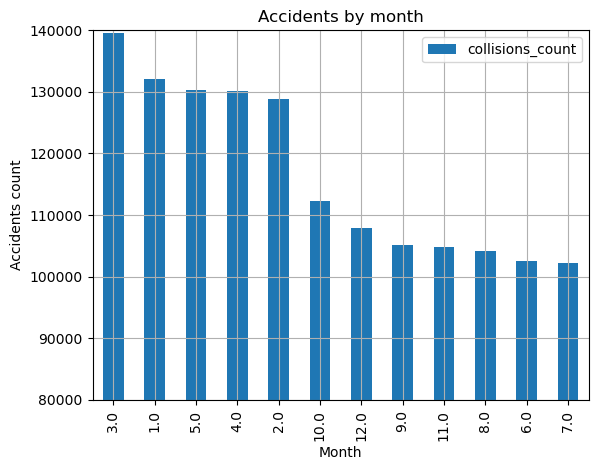

In [14]:
query = '''
SELECT EXTRACT(MONTH FROM collision_date) AS collisions_month, count(*) as collisions_count
FROM collisions AS c 
GROUP BY collisions_month
ORDER BY collisions_count DESC
'''
df = pd.read_sql_query(query, engine, index_col='collisions_month').astype(int)
df.plot(kind='bar',
        grid=True,
        xlabel='Month',
        ylabel='Accidents count',
        title='Accidents by month',
        ylim=(80000, 140000))
plt.show()

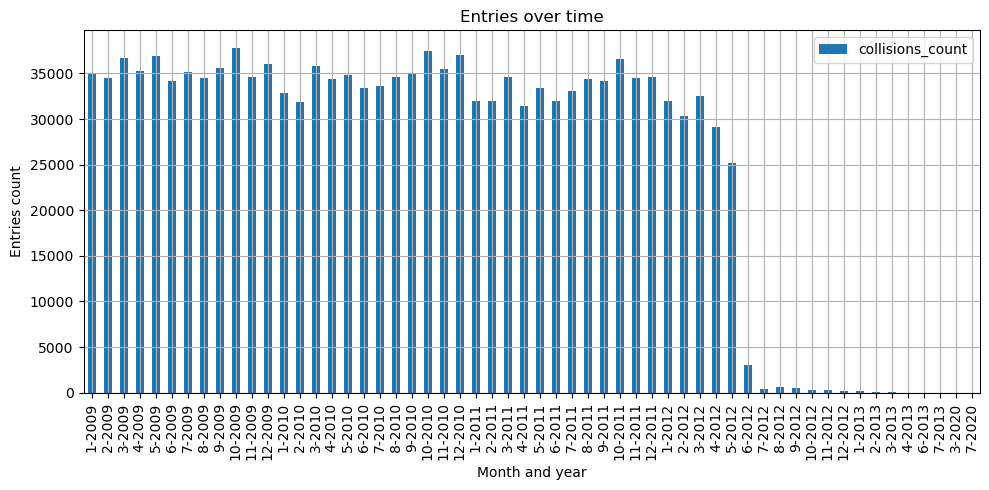

In [15]:
# проанализируем плотность данных по месяцам
query = '''
SELECT EXTRACT(YEAR FROM collision_date) AS collisions_year,
EXTRACT(MONTH FROM collision_date) AS collisions_month, 
count(*) as collisions_count
FROM collisions AS c 
GROUP BY collisions_year, collisions_month
ORDER BY collisions_year, collisions_month
'''
df = pd.read_sql_query(query, engine).astype(int)
# display(df)

df.plot(kind='bar',
        y='collisions_count',
        figsize=(10, 5),
        grid=True,
        xlabel='Month and year',
        ylabel='Entries count',
        title='Entries over time')
plt.xticks(ticks=df.index,
           labels=[f"{month}-{year}" for year, month in zip(df['collisions_year'], df['collisions_month'])])
plt.tight_layout()
plt.show()

## Предварительный вывод

* Поле `case_id` в базе данных имеет тип TEXT, хотя данные в нём являются целыми числами
* Если сравнивать количество аварий по месяцам, можно разделить месяцы на три группы:
* * Месяц с наибольшим количеством зафиксированных случаев: март
* * На втором месте идут месяцы с повышенным количеством аварий, примерно равные между собой: январь, февраль, апрель, май
* * Остальные месяцы с пониженным количеством аварий
* Если объединить март со второй группой, то получится, что в первой половине года (с января по май), каждый месяц наблюдается больше аварий по сравнению со второй половиной года
* Количество записей заметно падает, начиная с мая 2012 года. Не думаю, что это связано с тем, что количество аварий драматично сократилось. Заказчик предлагает использовать для обучения модели данные за 2012 год, но, возможно, лучше взять данные за 2011-2012 года

## Углублённый анализ таблиц

ТБД

# Подготовка данных для моделирования

Подготовим SQL запрос и загрузим данные на основе предложений от заказчика, привдённых в начальном разделе, но с изменённым временным интервалом, поскольку данные за 2012 год представлены в неравномерном количестве. Датасет может быть очень большой, поэтому загрузим только 1000 записей, чтобы оценить, какие поля выбрать.

In [39]:
query = '''
WITH
-- filter on damage type and date
collisions_filtered AS (
SELECT *
FROM collisions
WHERE collision_damage != 'scratch'
AND collision_date BETWEEN '2011-04-01' AND '2012-04-01'
),
-- filter on party type
parties_filtered AS (
SELECT *
FROM parties
WHERE party_type = 'car'
)
-- main query
SELECT *
FROM parties_filtered AS p
-- compare with collision info
INNER JOIN collisions_filtered AS c
ON p.case_id = c.case_id
-- add vehicle info
LEFT JOIN vehicles AS v 
ON p.case_id = v.case_id AND p.party_number = v.party_number
LIMIT 1000
;
'''

df_preview = pd.read_sql_query(query, engine)
df_preview.info()
df_preview.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1000 non-null   int64  
 1   case_id                      1000 non-null   object 
 2   party_number                 1000 non-null   int64  
 3   party_type                   1000 non-null   object 
 4   at_fault                     1000 non-null   int64  
 5   insurance_premium            965 non-null    float64
 6   party_sobriety               988 non-null    object 
 7   party_drug_physical          36 non-null     object 
 8   cellphone_in_use             897 non-null    float64
 9   case_id                      1000 non-null   object 
 10  county_city_location         1000 non-null   object 
 11  county_location              1000 non-null   object 
 12  distance                     1000 non-null   float64
 13  direction          

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,2569025,5542351,9,car,0,57.0,had not been drinking,None,0.0,5542351,2700,monterey,2798.0,north,0.0,clear,highway,fatal,9,vehicle code violation,dui,head-on,other motor vehicle,dry,normal,dark with no street lights,none,2012-02-22,20:43:00,1414204.0,5542351,9.0,coupe,manual,9.0
1,1822707,5136971,2,car,0,30.0,had not been drinking,None,NaN,5136971,3801,san francisco,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2011-04-14,11:40:00,NaN,None,NaN,None,None,NaN
2,1854487,5153989,2,car,0,18.0,had not been drinking,None,0.0,5153989,4400,santa cruz,50.0,north,0.0,clear,None,small damage,2,vehicle code violation,automobile right of way,sideswipe,other motor vehicle,dry,normal,daylight,none,2011-04-30,19:02:00,1014979.0,5153989,2.0,sedan,manual,7.0
3,1854711,5154112,2,car,0,NaN,None,None,NaN,5154112,1500,kern,3696.0,north,0.0,clear,highway,small damage,2,other than driver,other than driver (or pedestrian),hit object,other object,dry,construction,daylight,not functioning,2011-05-01,09:42:00,NaN,None,NaN,None,None,NaN
4,1855658,5154599,2,car,0,32.0,had not been drinking,None,0.0,5154599,5600,ventura,20.0,south,0.0,clear,None,small damage,2,vehicle code violation,automobile right of way,sideswipe,other motor vehicle,dry,normal,daylight,functioning,2011-04-08,15:03:00,1015614.0,5154599,2.0,sedan,auto,1.0


Некоторые факторы вроде трезвости водителя могут иметь значительное влияние на вероятность аварии, но мы не можем их учитывать в модели, поскольку они неизвестны до наступления аварии. Поэтому для формирования датасета выберем только те поля, информация в которых известна заранее.

Все идентификаторы сторон и кейсов также не войдут в обучающий датасет, поскольку не влияют на вероятность аварии